In [5]:
# the function is necessary to extract the standard error values from the wildboottest result table

def calculate_standard_error(t_statistic, parameter_estimate):
    """
    Calculate the standard error given a t-statistic and the parameter estimate.
    
    Parameters:
    t_statistic (float): The t-statistic value.
    parameter_estimate (float): The estimated parameter value (e.g., mean difference).
    
    Returns:
    float: The calculated standard error.
    """
    if t_statistic == 0:
        raise ValueError("t_statistic cannot be zero.")
    return abs(parameter_estimate / t_statistic)


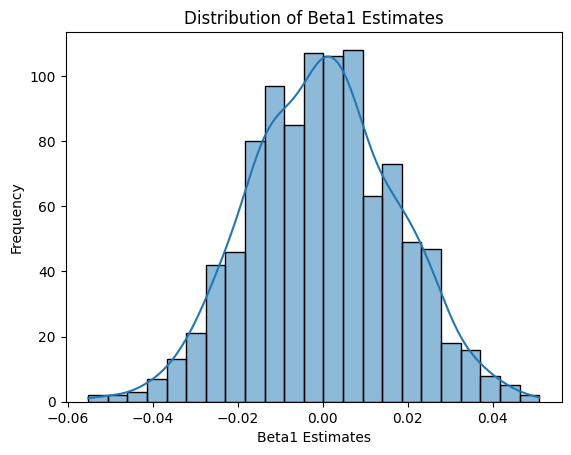

Number of times null hypothesis is rejected: 46 out of 1000 simulations
Type 1 Error: 0.046
Bias for Coefficient of Treatment : 1.4534043046824611e-05
MSE for Coefficient of Treatment : 0.0002930891298638062
RMSE for Coefficient of Treatment : 0.0002930891298638062
Average Standard Error: 0.017233847367786135
Standard Error of the beta_1 distribution: 0.017119839912376485
The confidence interval is (-0.033540352185211085, {0.03356942027130474})


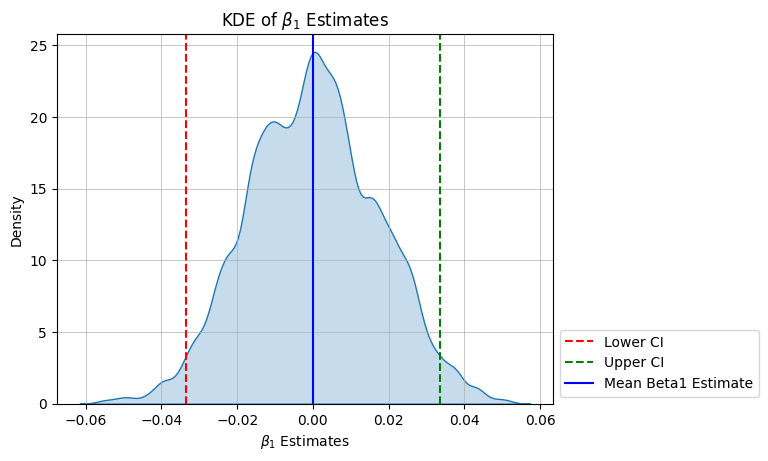

In [6]:
file_path = r'C:\Users\sneha\Downloads\cps_00006.csv.gz'

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smp
from wildboottest.wildboottest import wildboottest
from cps_data_agg import process_cps_data

alpha = 0.05  # Significance level
num_simulations = 1000

reject_count = 0  # Counter for the number of rejections
true_beta1_value = 0   # Initialising the counters
bias_values = []
squared_error_values = []
standard_error_values =[]
beta1_estimates = []

np.random.seed(42) # setting seed for reproducibility

df = process_cps_data(file_path)  # importing the data from process_cps_data module

for _ in range(num_simulations):

    data = df.copy()

    unique_statefips = data['STATEFIP'].unique()
    selected_statefips = np.random.choice(unique_statefips, size=num_of_states, replace=False)

    # Filter the DataFrame to only include rows with the selected STATEFIPs
    data = data[data['STATEFIP'].isin(selected_statefips)]
    
    states = data['STATEFIP'].unique()
    
    # Randomly selecting  half of the states to be in the treatment group
    
    treatment_states = np.random.choice(states, size=len(states)//2, replace=False)

    # Assigning treatment year to each treatment state, staggered between 1985 and 1995

    treatment_years = np.random.choice(range(1985, 1995), size=len(treatment_states), replace=True)
    state_to_treatment_year = dict(zip(treatment_states, treatment_years))

    # Adding a treatment column to the DataFrame

    data['TREATMENT'] = data.apply(lambda x: 1 if x['STATEFIP'] in treatment_states and x['YEAR'] >= state_to_treatment_year[x['STATEFIP']] else 0, axis=1)
  
    dummy_df = pd.get_dummies(data['STATEFIP'], prefix='STATEFIP', drop_first=True).astype(int)

    # Concatenate the dummy variables with the original DataFrame
    data = pd.concat([data, dummy_df], axis=1)

    dummy_df2 = pd.get_dummies(data['YEAR'], prefix='YEAR', drop_first=True).astype(int)

    # Concatenate the dummy variables with the original DataFrame
    data = pd.concat([data, dummy_df2], axis=1)

    columns_to_exclude = ['STATEFIP', 'YEAR', 'Residuals']

    X_columns =[col for col in data.columns if col not in columns_to_exclude]

    formula = "Residuals ~ "
    
    formula += " + ".join(X_columns)

    model = smp.ols(formula = formula , data = data)

    
    result = model.fit()
    wildboottest_results = wildboottest(model, param="TREATMENT", cluster=data['STATEFIP'], B= 400, bootstrap_type='11', show = False)
    wildboottest_results = pd.DataFrame(wildboottest_results)
    p_value = wildboottest_results['p-value'].iloc[0]
    param = result.params['TREATMENT']
    t_stat = wildboottest_results['statistic'].iloc[0] 

    
    # Checking  if null hypothesis for beta1 is rejected

    if p_value < alpha:
        reject_count += 1

    beta1_estimates.append(param)
    
    bias = np.mean(beta1_estimates) - true_beta1_value

    squared_error = (param - true_beta1_value) ** 2
    squared_error_values.append(squared_error)

    # Extracting the standard error of the 'TREATMENT' coefficient 

    standard_error = calculate_standard_error(t_stat, param)
    standard_error_values.append(standard_error)


type1_error = reject_count/ num_simulations
bias = np.mean(bias)
mse = np.mean(squared_error_values)
rmse = np.sqrt(mse)
average_standard_error = np.mean(standard_error_values)


std_error_beta_distribution = np.std(beta1_estimates)  # Calculating the standard error of the distribution of beta

confidence_interval = (
    np.mean(beta1_estimates) - 1.96 * std_error_beta_distribution,
    np.mean(beta1_estimates) + 1.96 * std_error_beta_distribution
)


print(f"Number of times null hypothesis is rejected: {reject_count} out of {num_simulations} simulations")
print(f"Type 1 Error: {type1_error}")
print(f"Bias for Coefficient of Treatment : {bias}")
print(f"MSE for Coefficient of Treatment : {mse}")
print(f"RMSE for Coefficient of Treatment : {mse}")
print(f"Average Standard Error: {average_standard_error}")
print(f"Standard Error of the beta_1 distribution: {std_error_beta_distribution}")
print(f'The confidence interval is {confidence_interval[0] , {confidence_interval[1]}}')

sns.kdeplot(beta1_estimates, bw_adjust=0.5, fill=True)
plt.xlabel(r'$\beta_1$ Estimates')  # Using LaTeX for beta_1
plt.ylabel('Density')
plt.title(r'Distribution of $\beta_1$ Estimates')


mean_beta1_estimate = np.mean(beta1_estimates) # Calculating mean of beta1 estimates for marking on plot

# Adding vertical lines for the confidence interval and the mean beta1 estimate

plt.axvline(x=confidence_interval[0], color='red', linestyle='--', label='Lower CI')
plt.axvline(x=confidence_interval[1], color='green', linestyle='--', label='Upper CI')
plt.axvline(x=mean_beta1_estimate, color='blue', linestyle='-', label='Mean Beta1 Estimate')

plt.legend(loc='lower left', bbox_to_anchor=(1, 0))

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.show()

